In [1]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
class SlicingEnv:
    def __init__(self, demand_data, slice_types, total_resources=100):
        self.demand_data = demand_data
        self.slice_types = slice_types
        self.total_resources = total_resources
        self.current_step = 0
        self.total_steps = len(demand_data)
        self.state_size = 2
        self.action_size = 11

    def reset(self):
        self.current_step = 0
        return self._get_state()

    def _get_state(self):
        load = self.demand_data[self.current_step]
        slice_type = self.slice_types[self.current_step]
        slice_id = {"emBB": 0, "URLLC": 1, "mMTC": 2}[slice_type]
        return np.array([load, slice_id], dtype=np.float32)

    def calculate_reward(self, action):
        load = self.demand_data[self.current_step]
        alloc_percent = action * 10
        alloc = alloc_percent / 100.0 * self.total_resources
        if alloc >= load:
            return 1 - (alloc - load) / self.total_resources
        else:
            return -1 * (load - alloc) / self.total_resources

    def step(self, action):
        reward = self.calculate_reward(action)
        self.current_step += 1
        done = self.current_step >= self.total_steps
        next_state = self._get_state() if not done else np.array([0.0, 0], dtype=np.float32)
        return next_state, reward, done

In [31]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self.build_model()
        self.memory = []

    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(64, input_shape=(self.state_size,), activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > 10000:
            self.memory.pop(0)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([sample[0] for sample in minibatch])
        targets = self.model.predict(states, verbose=0)
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                next_q = self.model.predict(next_state[np.newaxis, :], verbose=0)[0]
                target += self.gamma * np.amax(next_q)
            targets[i][action] = target
        self.model.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [32]:
# ---- Training Phase ----
np.random.seed(42)
demand_data = np.random.randint(10, 90, size=200)
slice_types = np.random.choice(["emBB", "URLLC", "mMTC"], size=200)

env = SlicingEnv(demand_data, slice_types)
agent = DQNAgent(state_size=2, action_size=11)

EPISODES = 50  # Reduced for faster run

for episode in range(EPISODES):
    print(f"\n🎮 Episode {episode + 1}/{EPISODES}")
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.replay(batch_size=64)  # Only once per episode
    print(f"✅ Episode Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.4f}")


🎮 Episode 1/50
✅ Episode Reward: 40.8700, Epsilon: 0.9950

🎮 Episode 2/50
✅ Episode Reward: 50.3100, Epsilon: 0.9900

🎮 Episode 3/50
✅ Episode Reward: 40.0900, Epsilon: 0.9851

🎮 Episode 4/50
✅ Episode Reward: 33.2900, Epsilon: 0.9801

🎮 Episode 5/50
✅ Episode Reward: 36.4500, Epsilon: 0.9752

🎮 Episode 6/50
✅ Episode Reward: 42.6300, Epsilon: 0.9704

🎮 Episode 7/50
✅ Episode Reward: 32.9100, Epsilon: 0.9655

🎮 Episode 8/50
✅ Episode Reward: 33.3700, Epsilon: 0.9607

🎮 Episode 9/50
✅ Episode Reward: 23.3900, Epsilon: 0.9559

🎮 Episode 10/50
✅ Episode Reward: 40.1300, Epsilon: 0.9511

🎮 Episode 11/50
✅ Episode Reward: 51.5300, Epsilon: 0.9464

🎮 Episode 12/50
✅ Episode Reward: 40.3300, Epsilon: 0.9416

🎮 Episode 13/50
✅ Episode Reward: 42.4700, Epsilon: 0.9369

🎮 Episode 14/50
✅ Episode Reward: 53.7100, Epsilon: 0.9322

🎮 Episode 15/50
✅ Episode Reward: 32.4700, Epsilon: 0.9276

🎮 Episode 16/50
✅ Episode Reward: 49.4300, Epsilon: 0.9229

🎮 Episode 17/50
✅ Episode Reward: 34.9900, Epsil

In [33]:
def evaluate_agent(agent, env, episodes=10, verbose=False):
    total_rewards = []

    original_epsilon = agent.epsilon  # Save current epsilon
    agent.epsilon = 0.0  # Disable exploration

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        step = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            step += 1

            if verbose:
                print(f"📍 Step {step} | Action: {action}, Reward: {reward:.4f}")

        total_rewards.append(total_reward)
        print(f"✅ Evaluation Episode {ep+1}: Total Reward = {total_reward:.4f}")

    avg_reward = np.mean(total_rewards)
    print(f"\n📊 Average Reward over {episodes} episodes: {avg_reward:.4f}")

    agent.epsilon = original_epsilon  # Restore original epsilon
    return total_rewards, avg_reward


In [37]:
total_rewards,avg_reward = evaluate_agent(agent, env, episodes=10, verbose=True)

📍 Step 1 | Action: 10, Reward: 0.6100
📍 Step 2 | Action: 10, Reward: 0.2400
📍 Step 3 | Action: 10, Reward: 0.8100
📍 Step 4 | Action: 10, Reward: 0.7000
📍 Step 5 | Action: 10, Reward: 0.3000
📍 Step 6 | Action: 10, Reward: 0.8400
📍 Step 7 | Action: 10, Reward: 0.8400
📍 Step 8 | Action: 10, Reward: 0.3300
📍 Step 9 | Action: 7, Reward: 0.4200
📍 Step 10 | Action: 10, Reward: 0.3100
📍 Step 11 | Action: 10, Reward: 0.6200
📍 Step 12 | Action: 7, Reward: 0.4100
📍 Step 13 | Action: 10, Reward: 0.3900
📍 Step 14 | Action: 10, Reward: 0.4700
📍 Step 15 | Action: 10, Reward: 0.1100
📍 Step 16 | Action: 10, Reward: 0.7300
📍 Step 17 | Action: 10, Reward: 0.6900
📍 Step 18 | Action: 10, Reward: 0.3000
📍 Step 19 | Action: 10, Reward: 0.4200
📍 Step 20 | Action: 10, Reward: 0.8500
📍 Step 21 | Action: 10, Reward: 0.6700
📍 Step 22 | Action: 10, Reward: 0.3100
📍 Step 23 | Action: 10, Reward: 0.5800
📍 Step 24 | Action: 10, Reward: 0.6800
📍 Step 25 | Action: 10, Reward: 0.5100
📍 Step 26 | Action: 10, Reward: 0.69

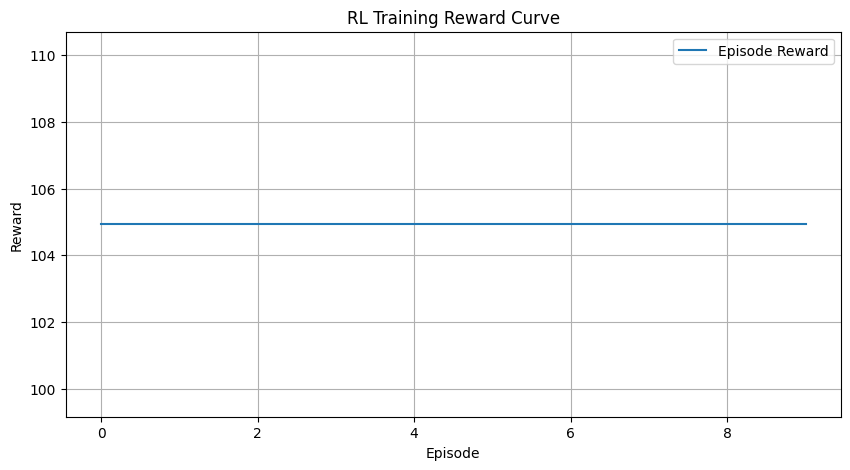

In [38]:
import matplotlib.pyplot as plt

def plot_rewards(reward_history):
    plt.figure(figsize=(10,5))
    plt.plot(reward_history, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("RL Training Reward Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(total_rewards)

In [ ]:
# Save model
def save_agent(agent, path="dqn_model.h5"):
    agent.model.save(path)
    print(f"✅ Model saved at: {path}")

# Load model
def load_agent(agent, path="dqn_model.h5"):
    agent.model = tf.keras.models.load_model(path)
    print(f"✅ Model loaded from: {path}")


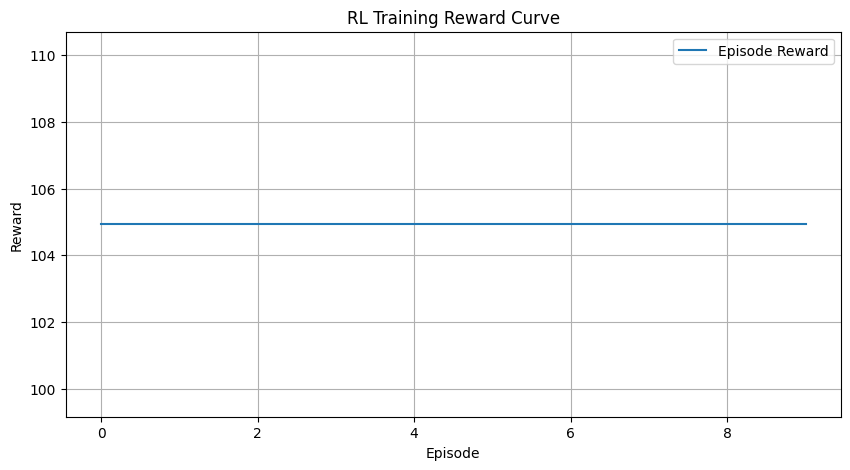

In [50]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque

# --- Dummy Environment ---
class SlicingEnv:
    def __init__(self):
        self.state_shape = (60, 11)  # 60 time steps, 11 features
        self.action_space = 3  # emBB, URLLC, mMTC
        self.reset()

    def reset(self):
        self.state = np.random.rand(*self.state_shape)
        self.steps = 0
        return self.state

    def step(self, action):
        self.steps += 1
        reward = np.random.rand() * (1 + action)  # Simulated reward
        done = self.steps >= 10
        next_state = np.random.rand(*self.state_shape)
        return next_state, reward, done

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = keras.Sequential([
            layers.Input(shape=self.state_shape),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis, ...], verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state[np.newaxis, ...], verbose=0)[0])
            target_f = self.model.predict(state[np.newaxis, ...], verbose=0)
            target_f[0][action] = target
            self.model.fit(state[np.newaxis, ...], target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# --- Load Pretrained Models ---
demand_model = keras.models.load_model("demand_model.h5")
classification_model = keras.models.load_model("classification_model.h5")

# --- Agent Training ---
env = SlicingEnv()
agent = DQNAgent(state_shape=env.state_shape, action_size=env.action_space)
episodes = 20

for ep in range(episodes):
    state = env.reset()

    # Predict traffic demand and slice type (mock input shape used here)
    model_input_demand = np.random.rand(1, 60, 11)   # for demand model
    model_input_class = np.random.rand(1, 3)         # for classification model
    
    predicted_demand = demand_model.predict(model_input_demand, verbose=0).flatten()
    predicted_slice_id = np.argmax(classification_model.predict(model_input_class, verbose=0), axis=1)[0]

    
    done = False
    total_reward = 0

    while not done:
        action = predicted_slice_id if np.random.rand() > agent.epsilon else agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    agent.replay()
    print(f"🎮 Episode {ep+1}/{episodes} | ✅ Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

# --- Save Final Model ---
agent.model.save("rl_slicing_agent.h5")
